In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from models import KeckTelescope
from influenc_funcs import gaussian_influence_function
from prysm.interferogram import render_synthetic_surface
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.x.dm import DM

from san import SpeckleAreaNulling   
from SANKalman import SANKalman     

In [26]:
def build_sim_env():
    """Build telescope, DM, and WFE identical to run_san.py."""
    Npup = 1024
    x, y, z = render_synthetic_surface(10, Npup, a=5e4, b=1/1000, c=3)
    wavefront_error = z / 2 
    keck = KeckTelescope(center_wavelength=1.65, bandwidth=1, starting_wfe=wavefront_error) 
    # --- detector parameters ------------
    keck.dark_current       = 5     # e⁻ /s
    keck.read_noise         = 1     # e⁻ /s
    keck.bias               = 10    # e⁻
    keck.bits               = 16
    keck.full_well_capacity = 2 ** keck.bits
    keck.conversion_gain    = 1     # e⁻ / ADU
    keck.exposure_time      = 100  # s

    Nd = keck.dark_current * keck.exposure_time
    NR = keck.read_noise 

    # --- DM ---------------
    nact, act_pitch, spa = 22, 3, 21       
    sampling_pitch = act_pitch / spa   
    
    x, y = make_xy_grid(keck.Npup, dx=sampling_pitch)
    r, _ = cart_to_polar(x, y)
    infl = gaussian_influence_function(r, act_pitch)
    dm = DM(infl, x.shape[0], nact, spa, rot=(0, 0, 0), shift=(0, 0))
    dm.act_pitch = act_pitch

    return keck, dm, wavefront_error, Nd, NR

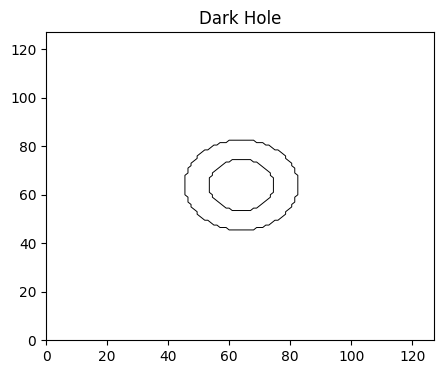

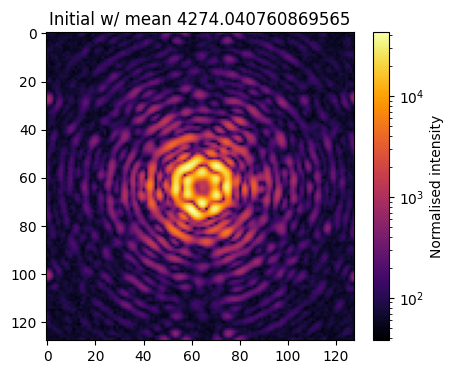

Iter 00 | ⟨I⟩_DH = 9.224e+03


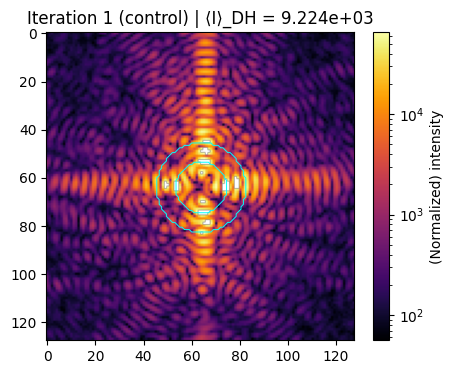

Iter 01 | ⟨I⟩_DH = 1.177e+04


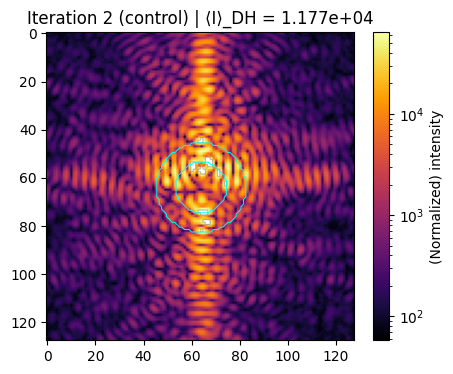

Iter 02 | ⟨I⟩_DH = 7.959e+03


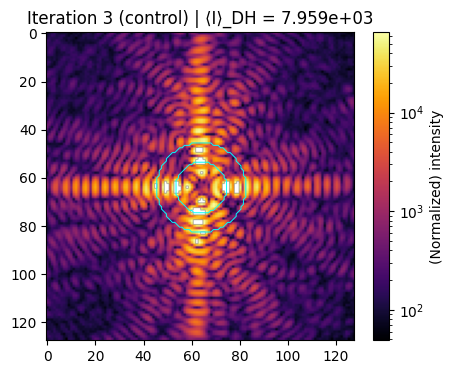

Iter 03 | ⟨I⟩_DH = 8.821e+03


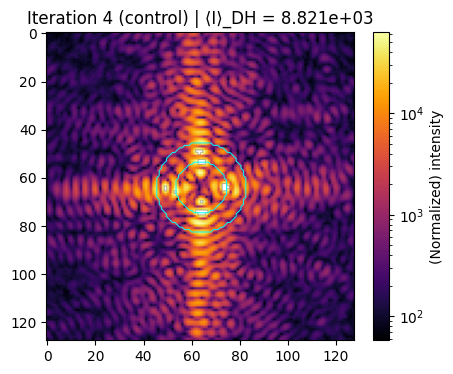

Iter 04 | ⟨I⟩_DH = 6.510e+03


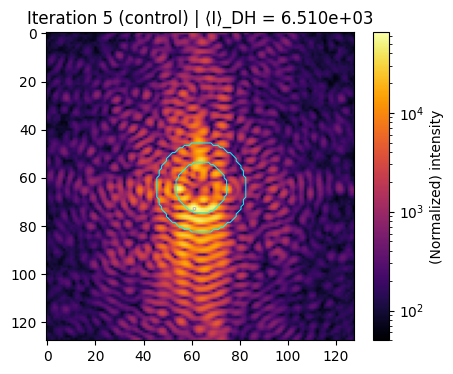

Iter 05 | ⟨I⟩_DH = 2.602e+03


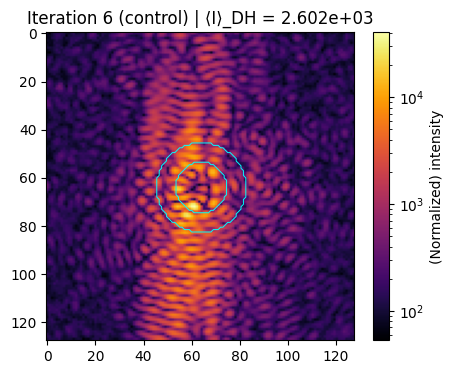

Iter 06 | ⟨I⟩_DH = 1.921e+03


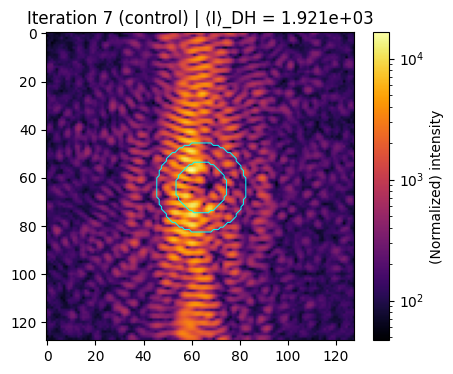

Iter 07 | ⟨I⟩_DH = 6.428e+02


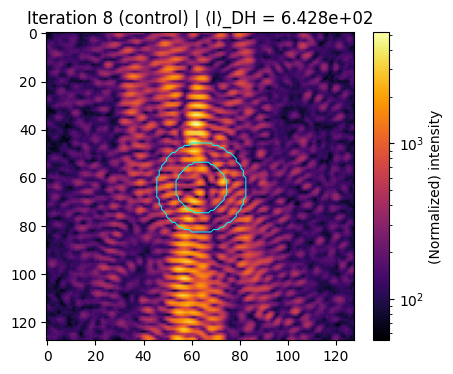

Iter 08 | ⟨I⟩_DH = 6.546e+02


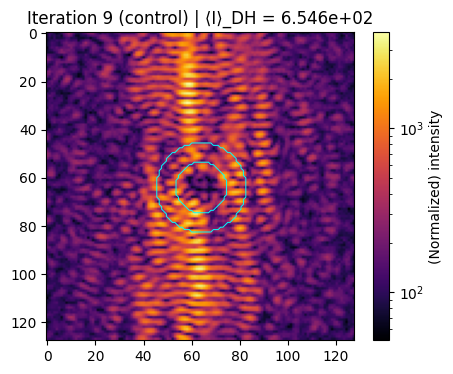

Iter 09 | ⟨I⟩_DH = 4.333e+02


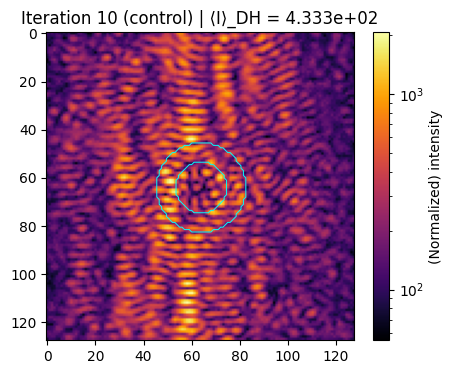

Iter 10 | ⟨I⟩_DH = 4.752e+02


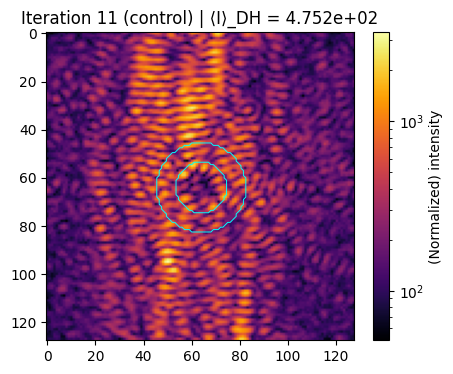

Iter 11 | ⟨I⟩_DH = 6.132e+02


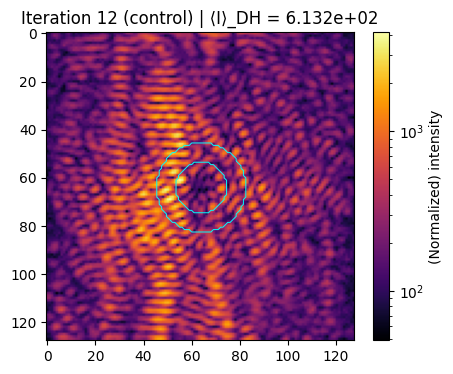

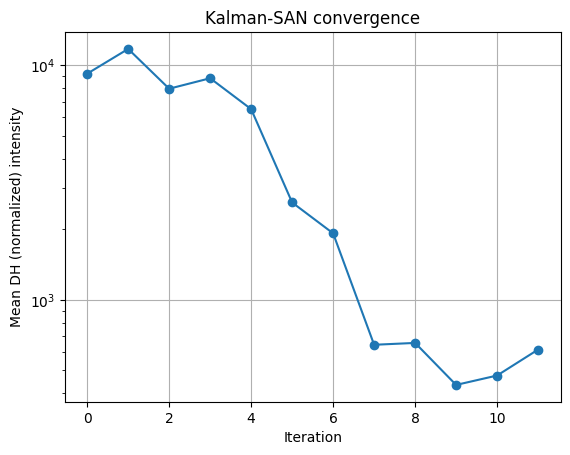

In [46]:
# USER SETTINGS
# ------------------------------------------------------------------
nsteps        = 12          # number of Kalman iterations
apply_control = True        # send DM correction u each step
show_plots    = True        # display DH image every iteration
# ------------------------------------------------------------------


# Build telescope, DM, fixed WFE
keck, dm, wfe_offset, Nd, NR = build_sim_env()     

global ref
# reference PSF peak
# ref = keck.get_coronagraph_image(include_fpm=False).max()
ref = 1

# SAN helper
san = SpeckleAreaNulling(
    propagation=keck.get_coronagraph_image,
    dx_img=keck.dx_img,
    epd=keck.epd, efl=keck.efl, wvl=keck.center_wavelength,
    dm=dm,
    IWA=4, OWA=7,
    angular_range=[-85, 85],
)
plt.figure(figsize=(5, 4))
plt.title("Dark Hole")
plt.contour(san.dh, levels=[0.5], colors='black', linewidths=0.7)
plt.show()

# Kalman filter
mask = san.dh.astype(bool)
kf = SANKalman(mask=mask,
               gain=keck.conversion_gain,
               q_process=1e-6)


# Function to get one 5-frame burst
def acquire_burst(sys, san_obj, dm, wfe_offset):
    images = []
    I0 = sys.get_coronagraph_image(include_fpm=True, wfe=dm.render(wfe=True)) / ref
    images.append(I0)

    for probe in (-san_obj.sin_probe, san_obj.sin_probe,
                  -san_obj.cos_probe, san_obj.cos_probe):
        dm.actuators += probe
        I = sys.get_coronagraph_image(include_fpm=True,
                                      wfe=dm.render(wfe=True) ) / ref
        dm.actuators -= probe
        images.append(I)

    I1m, I1p, I2m, I2p = images[1:]
    return I0, I1p, I1m, I2p, I2m


# Initialize P0, R with first burst
I0, I1p, I1m, I2p, I2m = acquire_burst(keck, san, dm, wfe_offset)
kf.initialize(I0, I1p, I1m, I2p, I2m, rigorous=True,
                   Ns=0, Nd=Nd, Nr=NR)

plt.figure(figsize=(5, 4))
mean0 = np.mean(I0[mask])
plt.title("Initial w/ mean " + str(mean0))
plt.imshow(I0, cmap='inferno', norm=LogNorm())
plt.colorbar(label='Normalised intensity')
plt.show()


# Kalman-SAN
means = []
for k in range(nsteps):
    u_signal = np.zeros_like(dm.actuators)
    if np.allclose(u_signal, 0):          # no control stroke this step
        kf.predict(control=False)
    else:                                 # stroke was applied
        kf.predict(control=True)

    I0, I1p, I1m, I2p, I2m = acquire_burst(keck, san, dm, wfe_offset)
    kf.update(I0, I1p, I1m, I2p, I2m)

    # control
    if apply_control:
        sin_c = -kf.x[0][:, None, None]
        cos_c = -kf.x[1][:, None, None]
        dm.actuators[:] += (sin_c * san.sin_modes + cos_c * san.cos_modes).sum(axis=0)

        u_signal = (sin_c * san.sin_modes + cos_c * san.cos_modes).sum(axis=0)

    else:
        u_signal = np.zeros_like(dm.actuators)

    # diagnostics
    img = keck.get_coronagraph_image(include_fpm=True,
                                     wfe=dm.render(wfe=True)) / ref
    means.append(np.mean(img[mask]))
    print(f"Iter {k:02d} | ⟨I⟩_DH = {means[-1]:.3e}")
    
    
    if show_plots:
        plt.figure(figsize=(5, 4))
        plt.title(f"Iteration {k+1} ({'control' if apply_control else 'open'}) | ⟨I⟩_DH = {means[-1]:.3e}")
        plt.imshow(img, cmap='inferno', norm=LogNorm())
        plt.colorbar(label='(Normalized) intensity')
        plt.contour(mask, levels=[0.5], colors='cyan', linewidths=0.7)
        plt.show()

        
# Convergence plot
plt.figure()
plt.semilogy(means, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Mean DH (normalized) intensity")
plt.title("Kalman-SAN convergence")
plt.grid(True)
plt.show()

Iter 00 | ⟨I⟩_DH = 9.685e+03


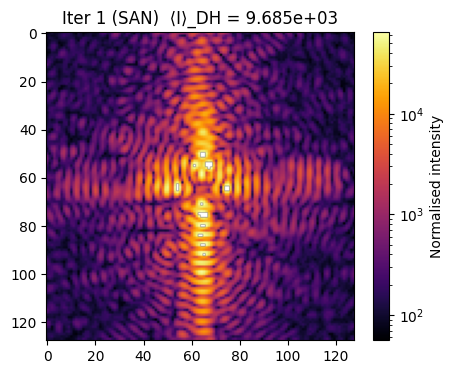

Iter 01 | ⟨I⟩_DH = 6.356e+02


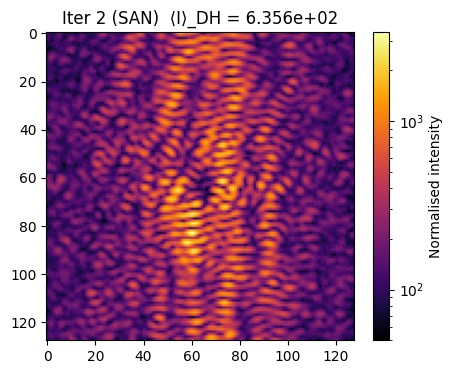

Iter 02 | ⟨I⟩_DH = 6.815e+02


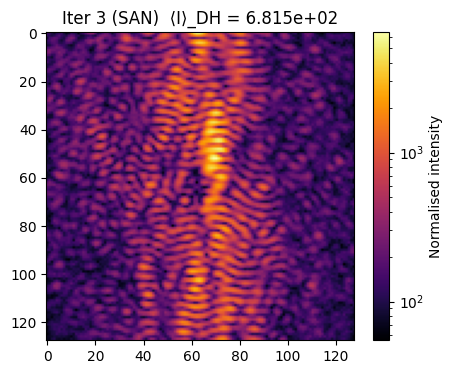

Iter 03 | ⟨I⟩_DH = 5.338e+02


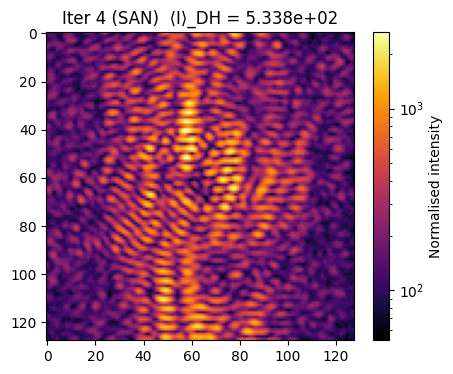

Iter 04 | ⟨I⟩_DH = 1.769e+02


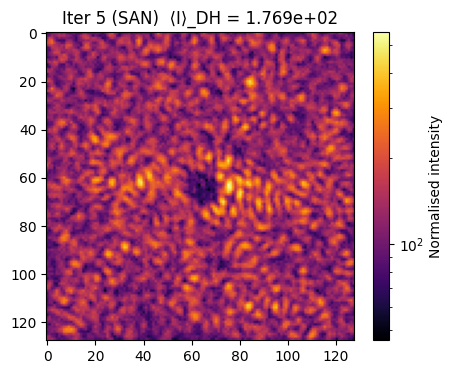

Iter 05 | ⟨I⟩_DH = 1.771e+02


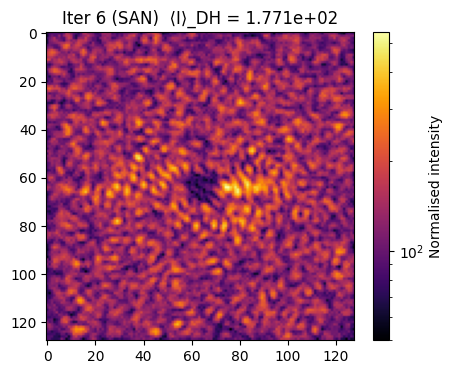

Iter 06 | ⟨I⟩_DH = 4.790e+02


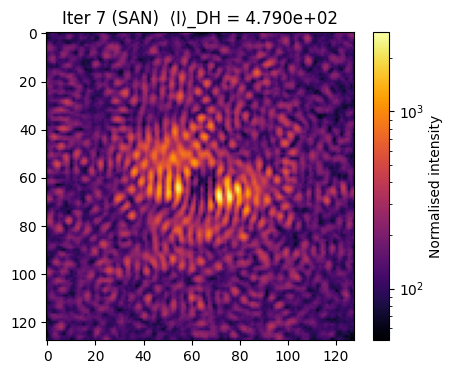

Iter 07 | ⟨I⟩_DH = 1.196e+03


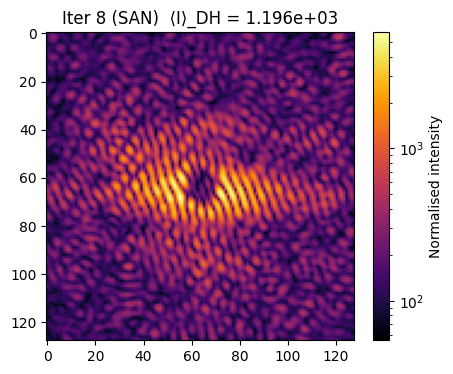

Iter 08 | ⟨I⟩_DH = 1.319e+03


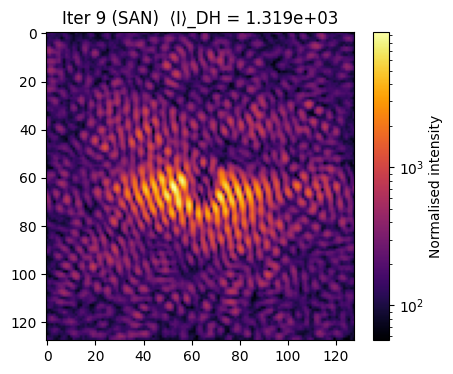

Iter 09 | ⟨I⟩_DH = 2.617e+02


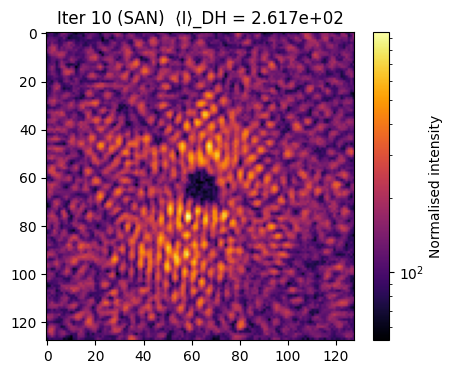

Iter 10 | ⟨I⟩_DH = 2.644e+02


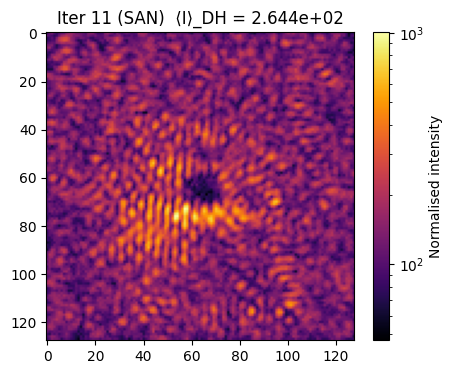

Iter 11 | ⟨I⟩_DH = 2.412e+02


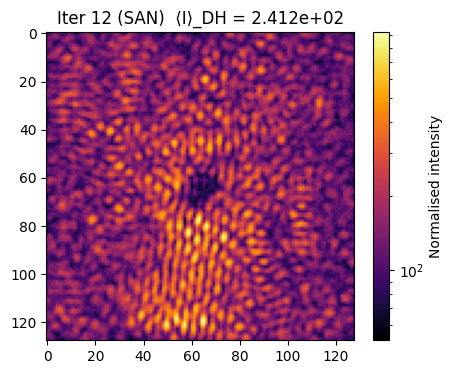

Iter 12 | ⟨I⟩_DH = 3.279e+02


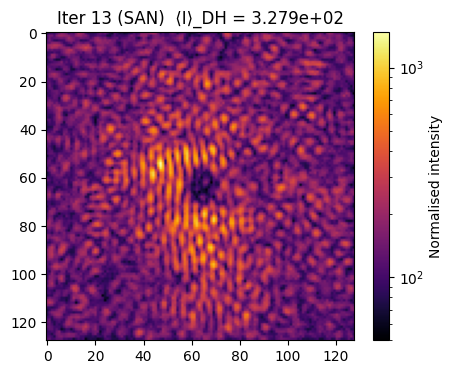

Iter 13 | ⟨I⟩_DH = 1.183e+03


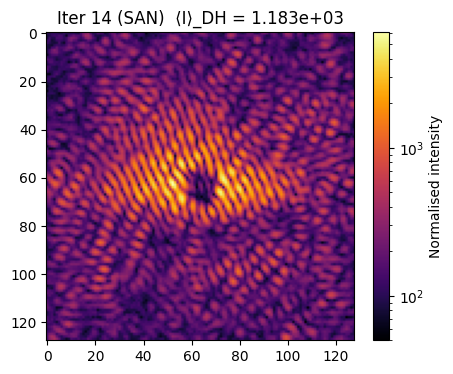

Iter 14 | ⟨I⟩_DH = 7.408e+02


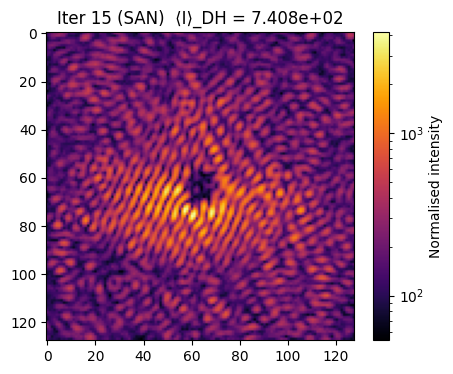

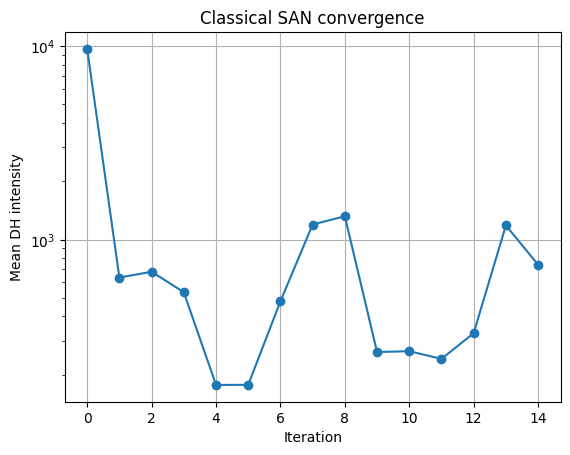

In [43]:
# SAN regularization for comparison

nsteps        = 15
apply_control = True
show_plots    = True
regularization = 1e-3           


means = []
for k in range(nsteps):

    # 5-frame burst
    I0, I1p, I1m, I2p, I2m = acquire_burst(keck, san, dm, wfe_offset)

    dE1   = (I1p - I1m) / 4
    dE2   = (I2p - I2m) / 4
    dE1sq = (I1p + I1m - 2*I0) / 2
    dE2sq = (I2p + I2m - 2*I0) / 2

    sin_coeffs = dE1 / (dE1sq + regularization)
    cos_coeffs = dE2 / (dE2sq + regularization)

    # restrict to dark hole
    dh_mask = san.dh.astype(bool) 
    sin_c = (-sin_coeffs[dh_mask]).reshape(-1, 1, 1) 
    cos_c = (-cos_coeffs[dh_mask]).reshape(-1, 1, 1)

    if apply_control:
        stroke = (sin_c * san.sin_modes + cos_c * san.cos_modes).sum(axis=0)
        dm.actuators += stroke

    # diagnostics
    img = keck.get_coronagraph_image(include_fpm=True,
                                     wfe=dm.render(wfe=True)) / ref
    means.append(np.mean(img[dh_mask]))
    print(f"Iter {k:02d} | ⟨I⟩_DH = {means[-1]:.3e}")

    if show_plots:
        plt.figure(figsize=(5,4))
        plt.title(f"Iter {k+1} (SAN)  ⟨I⟩_DH = {means[-1]:.3e}")
        plt.imshow(img, cmap='inferno', norm=LogNorm())
        plt.colorbar(label='Normalised intensity')
        plt.show()


# Convergence curve
plt.figure()
plt.semilogy(means, marker='o')
plt.xlabel('Iteration'); plt.ylabel('Mean DH intensity')
plt.title('Classical SAN convergence'); plt.grid(True); plt.show()


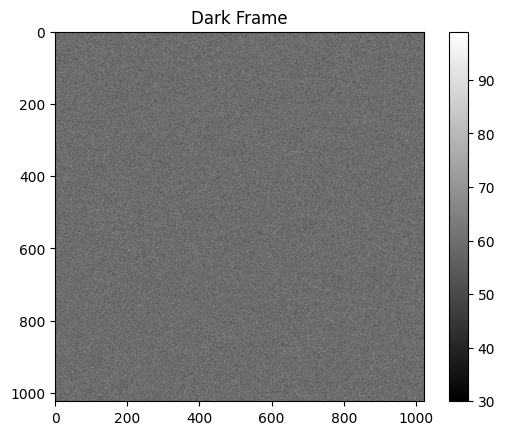

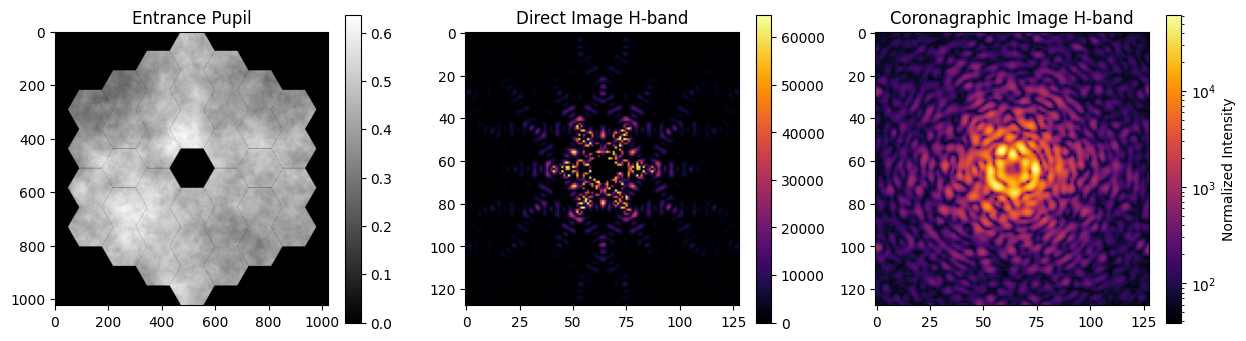

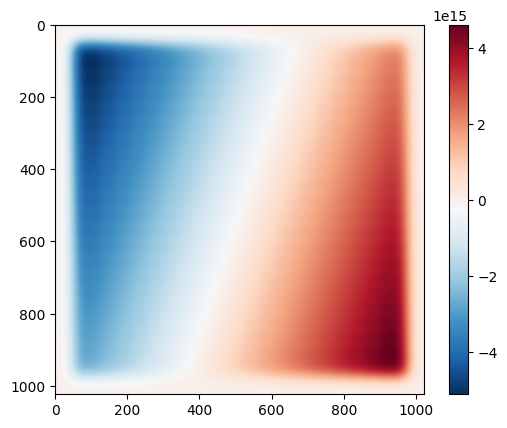

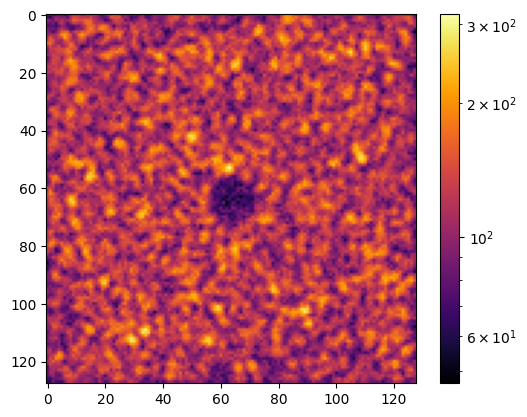

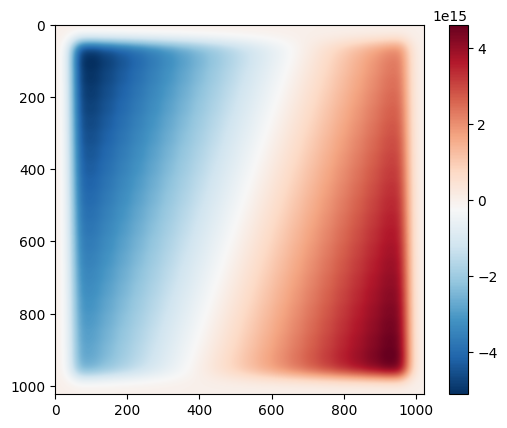

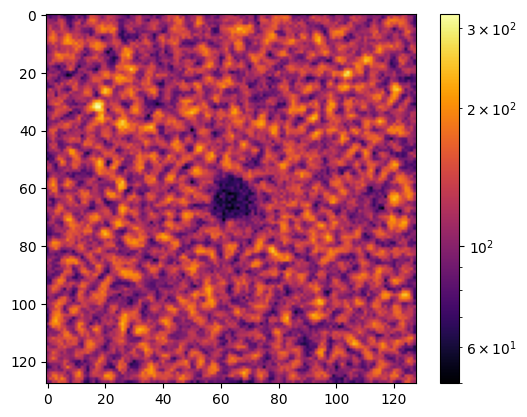

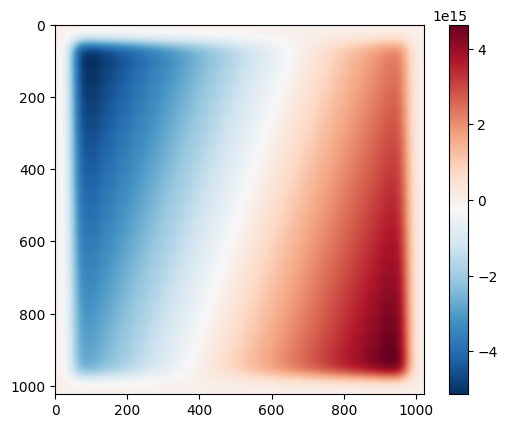

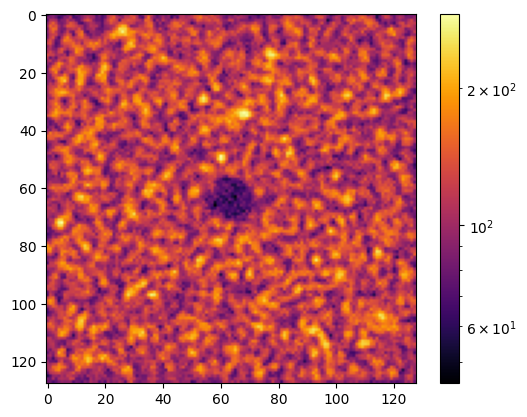

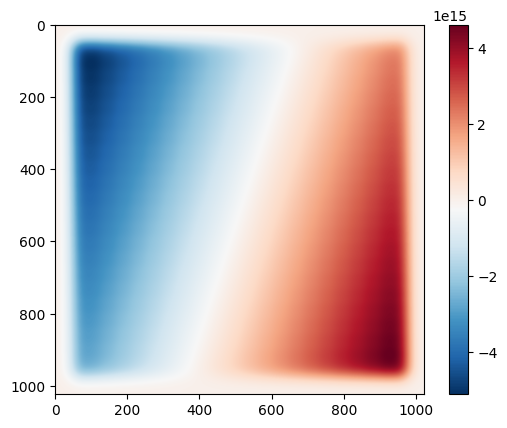

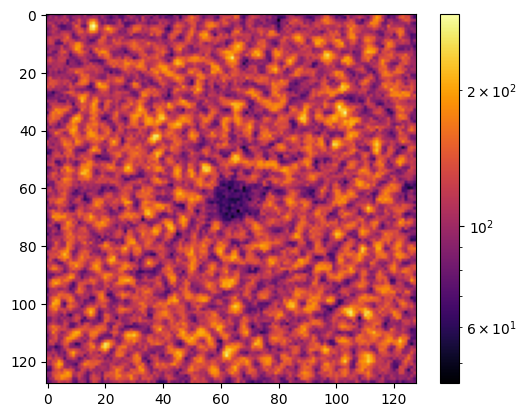

In [48]:
# run_san.py results

from models import KeckTelescope
from san import SpeckleAreaNulling
from influenc_funcs import gaussian_influence_function

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from prysm.interferogram import render_synthetic_surface
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.x.dm import DM

# Set up wavefront error - ideally this doesn't change
Npup = 1024
x, y, z = render_synthetic_surface(10, Npup, a=5e4, b=1/1000, c=3)
wavefront_error = z / 2

keck = KeckTelescope(center_wavelength=1.65, # microns
                     bandwidth=1, # percent
                     starting_wfe=wavefront_error)

# Detector Quantities can be set here
keck.dark_current = 5 # electrons / s
keck.read_noise = 1 # electrons / s
keck.bias = 10 # electrons
keck.bits = 16 # bits
keck.full_well_capacity = 2 ** keck.bits # bit depth
keck.conversion_gain = 1 # electrons / DN
keck.exposure_time = 100 # seconds

plt.figure()
plt.title("Dark Frame")
plt.imshow(keck.get_dark_image(), cmap="gray")
plt.colorbar()
plt.show()

# Here for normalization, not strictly necessary
ref = 1

plt.figure(figsize=[15, 4])
plt.subplot(131)
plt.title("Entrance Pupil")
plt.imshow(keck.get_entrance_pupil() * z, cmap="gray")
plt.colorbar()
plt.subplot(132)
plt.title("Direct Image H-band")
plt.imshow(keck.get_direct_image() / ref, cmap="inferno")
plt.colorbar()
plt.subplot(133)
plt.title("Coronagraphic Image H-band")
plt.imshow(keck.get_coronagraph_image(include_fpm=True, wfe=wavefront_error) / ref, cmap="inferno", norm=LogNorm())
plt.colorbar(label="Normalized Intensity")
plt.show()


# Set up a deformable mirror
nact = 22
act_pitch = 3
samples_per_act = 42
sampling_pitch = act_pitch / samples_per_act

x, y = make_xy_grid(keck.Npup, dx=sampling_pitch)
r, th = cart_to_polar(x, y)
influence_func = gaussian_influence_function(r, act_pitch)
Nout = x.shape[0]
dm = DM(influence_func, Nout, nact, samples_per_act, rot=(0,0,0), shift=(0,0))
dm.act_pitch = act_pitch


# Try out running SAN
san = SpeckleAreaNulling(
    propagation=keck.get_coronagraph_image,
    dx_img=keck.dx_img,
    epd=keck.epd,
    efl=keck.efl,
    wvl=keck.center_wavelength,
    dm=dm,
    IWA=4,
    OWA=7,
    angular_range=[-85, 85],
)


NSTEPS = 4
corrected_images = []
for i in range(NSTEPS):
    img = san.step(regularization=1e-4)
    corrected_images.append(img)
    plt.figure()
    plt.imshow(img, cmap="inferno", norm=LogNorm())
    plt.colorbar()
    plt.show()

